# Capstone Project - Data Science
## Number of venues in cities in Switzerland and number of venues per population

If you want to visit Switzerland and go to as many places as you can while you are there, this will help you to see which cities have the most venues, and which cities have the most venues per person.

This project analyses the total number of venues in some of Switzerland's cities, and the number of venues compared to the population of their respective cities.

First, the needed libraries and modules are imported. Then, the data is downloaded from GitHub, where it has been uploaded from another source. Some of the columns are renamed and dropped for easier data manipulation. The geocoders module is tested, and the cities of Switzerlands are mapped after that.

Using FourSquare's API, the number of venues of each city is retrieved. Then, the venues are grouped by cities, and in each city the total number of venues can be seen. The variable is "switzerland_venues_in_city"

A pie chart is created showing the cities, the bigger they are, the more venues they have. But, for better illustration, a bar chart is created where the total number of venues per city is set from the smallest from the largest number. Here, the bigger numbers are better. Geneve, Zug and Zurich are the leaders here, and Zurich has more than one third more venues than the second placed city.

But, the bigger cities can be crowded, and the venues as well. If you want to go somewhere where the distribution of the venues per population is bigger, we can find out where. Dividing the number of population of each city with the number of venues, we can find out which city has the most venues per population.

The smaller numbers are better here, and a pie chart and a bar chart are created. Here, Zug, Appenzel and Arau are the leaders, so you can go there without worry of being left out without reservations.

Other analyes are also done, and the most popular categories of venues for each city are also there. Based on these recommendations, people can get more ready to visit Switzerland.

In [42]:
import pandas as pd
import numpy as np

In [ ]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

In [63]:
url = 'https://raw.githubusercontent.com/dminovski0/Coursera_Capstone/master/ch.csv'

df = pd.read_csv(url)
df = df.drop(['country', 'iso2', 'admin', 'capital', 'population_proper'], axis=1)
df = df[pd.notnull(df['population'])]

df.shape

(27, 4)

In [64]:
switzerland_data = df
switzerland_data.rename(columns={'lat' : 'Latitude', 'lng' : 'Longitude'}, inplace=True)
switzerland_data.head()

,city,Latitude,Longitude,population
0,Geneva,46.195602,6.148113,1240000.0
1,Zürich,47.366667,8.550000,1108000.0
2,Basel,47.558395,7.573271,830000.0
3,Bern,46.916667,7.466667,275329.0
4,Lausanne,46.533333,6.666667,265702.0


In [61]:
address = 'Geneve, CH'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Geneve are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Geneve are 46.2017559, 6.1466014.


In [227]:
# create map of Switzerland cities using latitude and longitude values
map_switzerland = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, label in zip(switzerland_data['Latitude'], switzerland_data['Longitude'], switzerland_data['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_switzerland)  
    
map_switzerland

In [76]:
CLIENT_ID = 'DZF3PLPP20F5AVBRK3D2ZKWSZJAQCXOBFXTA2BUUBUOK0GE3' # your Foursquare ID
CLIENT_SECRET = 'WLDJPTBPOLOZXGOM0NYVNVYOD1M4143LOZDHK4XIUG3XEBEG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DZF3PLPP20F5AVBRK3D2ZKWSZJAQCXOBFXTA2BUUBUOK0GE3
CLIENT_SECRET:WLDJPTBPOLOZXGOM0NYVNVYOD1M4143LOZDHK4XIUG3XEBEG


In [74]:
switzerland_data.loc[0, 'city']

'Geneva'

In [75]:
city_latitude = switzerland_data.loc[0, 'Latitude'] # neighborhood latitude value
city_longitude = switzerland_data.loc[0, 'Longitude'] # neighborhood longitude value

city_name = switzerland_data.loc[0, 'city'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

Latitude and longitude values of Geneva are 46.195602, 6.1481129999999995.


In [150]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=DZF3PLPP20F5AVBRK3D2ZKWSZJAQCXOBFXTA2BUUBUOK0GE3&client_secret=WLDJPTBPOLOZXGOM0NYVNVYOD1M4143LOZDHK4XIUG3XEBEG&v=20180605&ll=46.195602,6.1481129999999995&radius=500&limit=1000'

In [151]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [152]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
switzerland_venues = getNearbyVenues(names=switzerland_data['city'],
                                   latitudes=switzerland_data['Latitude'],
                                   longitudes=switzerland_data['Longitude']
                                  )
switzerland_venues.shape

In [205]:
print(switzerland_venues.shape)
switzerland_venues.head()

(465, 7)


,city,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Geneva,46.195602,6.148113,Jules Verne,46.194127,6.145376,French Restaurant
1,Geneva,46.195602,6.148113,Bistro de la Tour,46.195398,6.146724,Bistro
2,Geneva,46.195602,6.148113,Le Socrate,46.195686,6.146486,French Restaurant
3,Geneva,46.195602,6.148113,Pasta d'Oro,46.194697,6.147558,Pizza Place
4,Geneva,46.195602,6.148113,Les Enfants Terribles,46.193950,6.145032,Music Venue


In [206]:
switzerland_venues.groupby('city').count()
switzerland_venues.head()

,city,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Geneva,46.195602,6.148113,Jules Verne,46.194127,6.145376,French Restaurant
1,Geneva,46.195602,6.148113,Bistro de la Tour,46.195398,6.146724,Bistro
2,Geneva,46.195602,6.148113,Le Socrate,46.195686,6.146486,French Restaurant
3,Geneva,46.195602,6.148113,Pasta d'Oro,46.194697,6.147558,Pizza Place
4,Geneva,46.195602,6.148113,Les Enfants Terribles,46.193950,6.145032,Music Venue


In [269]:
switzerland_venues_in_city = switzerland_venues.groupby('city').count()
switzerland_venues_in_city = switzerland_venues_in_city.drop(['Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1)
switzerland_venues_in_city.head()

,Latitude,Longitude,Venue
city,,,
Aarau,23,23,23
Altdorf,6,6,6
Appenzell,12,12,12
Basel,13,13,13
Bellinzona,18,18,18


In [211]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


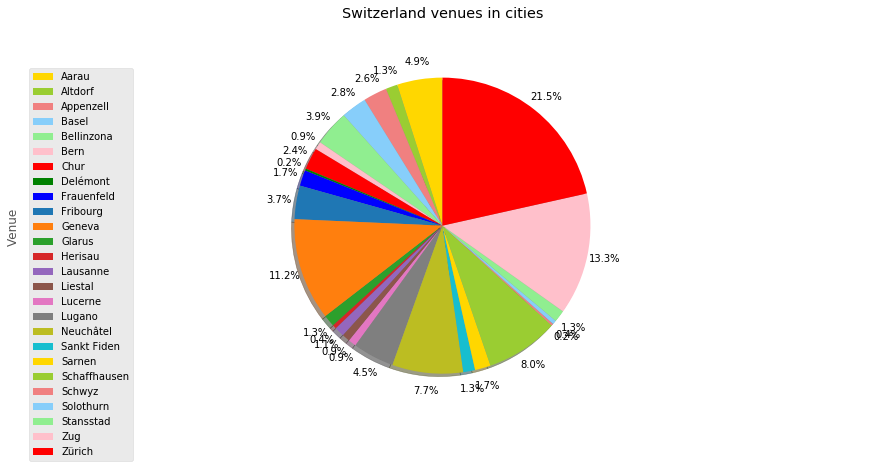

In [226]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'red', 'green', 'blue', "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

switzerland_venues_in_city['Venue'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list  # add custom colors
                             # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Switzerland venues in cities', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=switzerland_venues_in_city.index, loc='upper left') 

plt.show()

In [319]:
switzerland_city_bar = switzerland_venues_in_city
switzerland_city_bar = switzerland_city_bar.reset_index()
switzerland_city_bar = switzerland_city_bar.sort_values('Venue', ascending=True)
switzerland_city_bar = switzerland_city_bar.drop(['Latitude', 'Longitude'], axis=1)
switzerland_city_bar = switzerland_city_bar.set_index('city')
switzerland_city_bar.head()

,Venue
city,
Schwyz,1
Delémont,1
Herisau,2
Solothurn,2
Lucerne,4


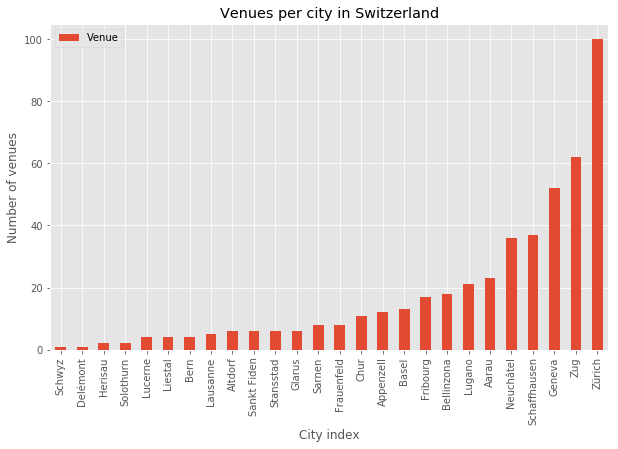

In [277]:
switzerland_city_bar.plot(kind='bar', figsize=(10, 6))
plt.xlabel('City index') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Venues per city in Switzerland') # add title to the plot
plt.show()

In [282]:
switzerland_venues_population = switzerland_data.merge(switzerland_venues_in_city, on='city')
switzerland_venues_population.head()

,city,Latitude_x,Longitude_x,population,Latitude_y,Longitude_y,Venue
0,Geneva,46.195602,6.148113,1240000.0,52,52,52
1,Zürich,47.366667,8.550000,1108000.0,100,100,100
2,Basel,47.558395,7.573271,830000.0,13,13,13
3,Bern,46.916667,7.466667,275329.0,4,4,4
4,Lausanne,46.533333,6.666667,265702.0,5,5,5


In [ ]:
switzerland_venues_population = switzerland_venues_population.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y'], axis=1)

In [289]:
switzerland_venues_population['divide'] = switzerland_venues_population['population'] / switzerland_venues_population['Venue']
switzerland_venues_population.head()

,city,population,Venue,divide
0,Geneva,1240000.0,52,23846.153846
1,Zürich,1108000.0,100,11080.000000
2,Basel,830000.0,13,63846.153846
3,Bern,275329.0,4,68832.250000
4,Lausanne,265702.0,5,53140.400000


In [ ]:
switzerland_venues_population = switzerland_venues_population.drop(['population', 'Venue'], axis=1)

In [317]:
switzerland_venues_population.sort_values('divide', ascending=False).head()

,city,divide
3,Bern,68832.250000
2,Basel,63846.153846
5,Lucerne,62500.000000
4,Lausanne,53140.400000
0,Geneva,23846.153846


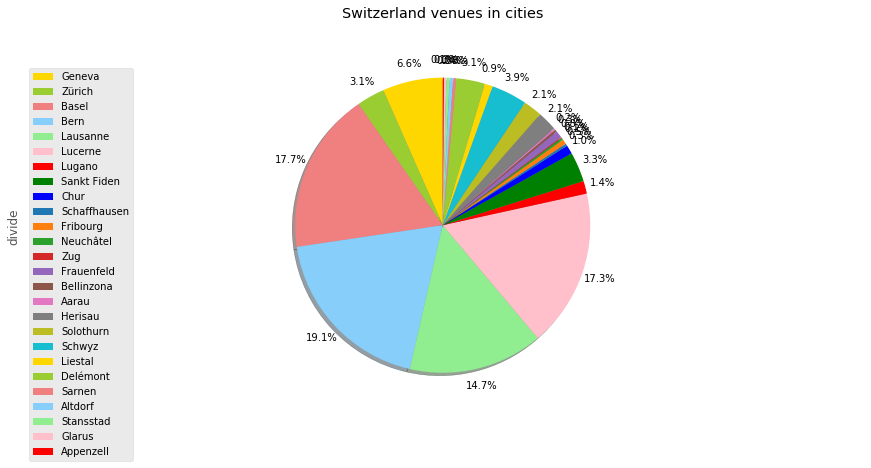

In [303]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'red', 'green', 'blue', "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

switzerland_venues_population['divide'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list  # add custom colors
                             # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Switzerland venues in cities', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=switzerland_venues_population['city'], loc='upper left') 

plt.show()

In [313]:
switzerland_venues_population_bar = switzerland_venues_population
switzerland_venues_population_bar = switzerland_venues_population_bar.set_index('city')
switzerland_venues_population_bar = switzerland_venues_population_bar.sort_values('divide')

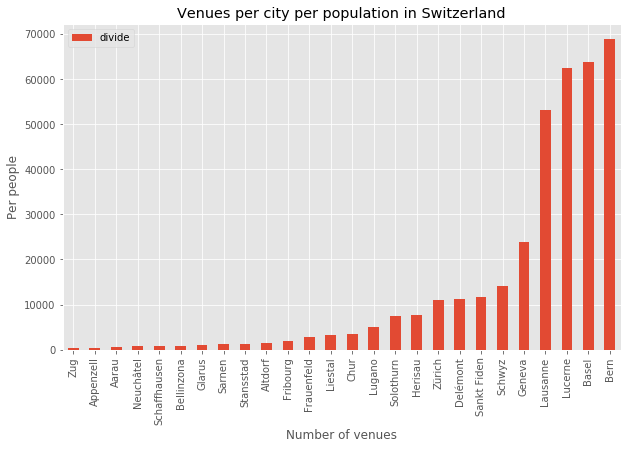

In [315]:
switzerland_venues_population_bar.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Number of venues') # add to x-label to the plot
plt.ylabel('Per people') # add y-label to the plot
plt.title('Venues per city per population in Switzerland') # add title to the plot
plt.show()

In [156]:
print('There are {} uniques categories.'.format(len(switzerland_venues['Venue Category'].unique())))

There are 129 uniques categories.


In [157]:
# one hot encoding
switzerland_onehot = pd.get_dummies(switzerland_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
switzerland_onehot['city'] = switzerland_venues['city'] 

# move city column to the first column
fixed_columns = [switzerland_onehot.columns[-1]] + list(switzerland_onehot.columns[:-1])
switzerland_onehot = switzerland_onehot[fixed_columns]

switzerland_onehot.head()

,city,American Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bank,Bar,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Yoga Studio
0,Geneva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Geneva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Geneva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Geneva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Geneva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
switzerland_onehot.shape

(465, 130)

In [159]:
switzerland_grouped = switzerland_onehot.groupby('city').mean().reset_index()
switzerland_grouped.head()

,city,American Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bank,Bar,...,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Yoga Studio
0,Aarau,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.043478,0.000000,0.0,0.000000,0.0,0.0
1,Altdorf,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,Appenzell,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.083333,0.000000,0.0,0.000000,0.0,0.0
3,Basel,0.0,0.0,0.0,0.000000,0.0,0.0,0.076923,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.153846,0.0,0.076923,0.0,0.0
4,Bellinzona,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.055556,...,0.0,0.0,0.0,0.0,0.055556,0.000000,0.0,0.000000,0.0,0.0


In [160]:
switzerland_grouped.shape

(26, 130)

In [ ]:
num_top_venues = 5

for city in switzerland_grouped['city']:
    print("----"+city+"----")
    temp = switzerland_grouped[switzerland_grouped['city'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [164]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [165]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
switzerland_venues_sorted = pd.DataFrame(columns=columns)
switzerland_venues_sorted['city'] = switzerland_grouped['city']

for ind in np.arange(switzerland_grouped.shape[0]):
    switzerland_venues_sorted.iloc[ind, 1:] = return_most_common_venues(switzerland_grouped.iloc[ind, :], num_top_venues)

switzerland_venues_sorted.head()

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarau,Platform,Café,Irish Pub,Pharmacy,Museum,Plaza,Mobile Phone Shop,Restaurant,Mexican Restaurant,Sandwich Place
1,Altdorf,Hotel,Gastropub,Supermarket,Plaza,Post Office,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Discount Store
2,Appenzell,Swiss Restaurant,Café,Hotel,Restaurant,Museum,Steakhouse,Plaza,Train Station,City,Cosmetics Shop
3,Basel,Tram Station,Coffee Shop,Bakery,Bus Station,Middle Eastern Restaurant,Pizza Place,Food & Drink Shop,Supermarket,Grocery Store,Hotel
4,Bellinzona,Italian Restaurant,Plaza,Swiss Restaurant,Pizza Place,Supermarket,Hotel,Department Store,Castle,Bistro,Bar


In [125]:
# set number of clusters
kclusters = 5

switzerland_grouped_clustering =switzerland_grouped.drop('city', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(switzerland_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]
kmeans.labels_.astype(int)

array([1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4,
       2, 1, 1, 1])

In [126]:
# add clustering labels
switzerland_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

switzerland_merged = switzerland_data

# merge switzerland_grouped with switzerland_data to add latitude/longitude for each city
switzerland_merged = switzerland_merged.join(switzerland_venues_sorted.set_index('city'), on='city')
switzerland_merged['Cluster Labels'].fillna(0, inplace=True)
switzerland_merged = switzerland_merged.astype({'Cluster Labels' : int})

switzerland_merged.head() # check the last columns!

,city,Latitude,Longitude,population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Geneva,46.195602,6.148113,1240000.0,1,French Restaurant,Bar,Burger Joint,Italian Restaurant,Plaza,Tea Room,Hotel,Café,Coffee Shop,Theater
1,Zürich,47.366667,8.550000,1108000.0,1,Italian Restaurant,Hotel,Swiss Restaurant,Coffee Shop,Plaza,Lounge,Café,Bar,French Restaurant,Dessert Shop
2,Basel,47.558395,7.573271,830000.0,1,Tram Station,Coffee Shop,Bakery,Bus Station,Middle Eastern Restaurant,Pizza Place,Food & Drink Shop,Supermarket,Grocery Store,Hotel
3,Bern,46.916667,7.466667,275329.0,1,Japanese Restaurant,Train Station,Supermarket,Electronics Store,Dance Studio,Discount Store,Diner,Dessert Shop,Department Store,Deli / Bodega
4,Lausanne,46.533333,6.666667,265702.0,1,IT Services,Dance Studio,Restaurant,Sushi Restaurant,Football Stadium,Diner,Dessert Shop,Department Store,Deli / Bodega,Cupcake Shop


In [166]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(switzerland_merged['Latitude'], switzerland_merged['Longitude'], switzerland_merged['city'], switzerland_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters